# Hồi quy Ridge Regression (diễn giải)

Trong notebook này, chúng ta sẽ chạy hồi quy Ridge nhiều lần với các L2 penalty khác nhau để xem cái nào sẽ khớp tốt nhất. Chúng ta sẽ tham khảo lại ví dụ hồi quy đa thức để thấy được hiệu quả của điều chuẩn L2.
* Sử dụng triển khai được tích hợp sẵn của Hồi quy Ridge từ sklearn để chạy hồi quy đa thức.
* Sử dụng matplotlib để trực quan hóa hồi quy đa thức.
* Sử dụng triển khai trên để chạy hồi quy đa thức, lần này là với L2 penalty.
* Sử dụng matplotlib để trực quan hóa hồi quy đa thức với điều chuẩn L2.
* Chọn L2 penalty tốt nhất sử dụng kiểm định chéo.
* Đánh giá khớp cuối cùng sử dụng dữ liệu kiểm tra.

Chúng ta sẽ tiếp tục sử dụng dữ liệu giá nhà từ các notebook trước đó. (Trong bài tập lập trình tiếp theo, chúng ta sẽ triển khai thuật toán học hồi quy Ridge với gradient descent.)

## Thư viện

In [2]:
import pandas as pd
import sklearn, pandas
import numpy as np

## Hồi quy đa thức

Chúng ta sẽ lấy nguồn từ lab trước (*lab-3.ipynb*), đã có hàm tạo DataFrame với các cột chứa lũy thừa của một đầu vào đã biết. Copy và paste hàm `polynomial_dataframe`:

In [3]:
def polynomial_dataframe(feature, degree):

    data = pd.DataFrame()

    for i in range(1, degree +1):

        label = 'power_' + str(i)

        data[label] = feature  ** i
    return data

In [4]:
mock = np.array([1.,2.,3.])
print(polynomial_dataframe(mock,3))

   power_1  power_2  power_3
0      1.0      1.0      1.0
1      2.0      4.0      8.0
2      3.0      9.0     27.0


Chúng ta sẽ dùng matplotlib để hiển thị xem hồi quy đa thức trông như thế nào với dữ liệu nhà ở.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
full_data = pandas.read_csv("house_data/kc_house_data.csv", index_col=0)

Ở lab trước, chúng ta đã dùng biến 'sqft_living'. Để vẽ biểu đồ (nối các chấm), chúng ta cần sắp xếp theo theo giá trị 'sqft_living'; với các ngôi nhà có cùng diện tích, chúng ta sẽ chọn theo giá.

In [7]:
full_data = full_data.sort_values(['sqft_living', 'price'])

Hãy xem lại  mô hình đa thức bậc 15 sử dụng đầu vào 'sqft_living'. Tạo các đặc trưng đa thức bậc 15 sử dụng `polynomial_dataframe()` và khớp mô hình với các đặc trưng này, sử dụng L2 penalty của `1e-5`:

In [8]:
l2_small_penalty = 1e-5


Lưu ý: Nếu có quá nhiều đặc trưng và quá ít điểm dữ liệu, giải pháp có thể không ổn định về mặt số học, đôi khi có thể dẫn đến các kết quả kỳ lạ không thể đoán trước. Do đó, thay vì không sử dụng điều chuẩn, chúng ta sẽ đưa vào một ít điều chuẩn (`l2_penalty=1e-5`) để làm cho giải pháp ổn định về mặt số học. (Trong bài giảng, chúng ta đã thảo luận là điều chuẩn cũng có thể giúp ổn định số, ở đây chúng ta có một ví dụ thực tế.)

Với L2 penalty trên, hãy khớp mô hình và in ra các trọng số tìm được. Có thể tham khảo [Hồi quy Ridge của sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

Chúng ta cũng có thể chuẩn hóa các giá trị cho phân phối Gauss qua [StandardScaler của sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), vì các giá trị penalty điều chỉnh độ lớn của trọng số, tỷ lệ nghịch với các giá trị đa thức (rất lớn).  

In [9]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
# Mức độ trợ giúp: vừa phải
scaler = StandardScaler()
poly_data = polynomial_dataframe(full_data['sqft_living'], 15)
poly_features = scaler.fit_transform(poly_data.values)
poly_labels = full_data['price'].values
# hãy tự thực hiện tiếp
ridge_model = Ridge(alpha=l2_small_penalty).fit(poly_features, poly_labels)
print(ridge_model.coef_)

[  66302.8861112    69629.18248658  318517.57918021 -214032.49153798
  -11942.64888294    -785.01485673   -2425.65579973    1844.69134914
   -1112.58390264   -1300.13430765    1164.71408109    3544.54416876
    2157.26004229   -2039.47889013     347.69928627]


***QUIZ:  Giá trị tìm được cho các hệ số của đặc trưng `power_1` là?***

# Quan sát overfitting


Theo lab trước, khớp đa thức bậc 15 thay đổi rất nhiều mỗi khi dữ liệu thay đổi. Cụ thể, khi chúng ta chia dữ liệu bán nhà thành 4 tập con và khớp mô hình bậc 15 thì kết quả của mỗi tập con lại khác; mô hình có *phương sai cao*. Chúng ta sẽ thấy ngay sau đây, hồi quy Ridge sẽ giảm phương sai đó. Nhưng trước tiên, chúng ta cần tái hiện lại những gì đã làm.

Trước tiên, chia dữ liệu thành 4 tập con có kích thước tương tự nhau và gọi chúng là `set_1`, `set_2`, `set_3`, và `set_4`. Sử dụng hàm `train_test_split` và thiết lập `random_state=0`. 

In [10]:
from sklearn.model_selection import train_test_split
seed = 20
big_set_1, big_set_2 = train_test_split(full_data, train_size=0.5, test_size=0.5, random_state=0)
set_1, set_2 = train_test_split(big_set_1, train_size=0.5, test_size=0.5, random_state=0)
set_3, set_4 = train_test_split(big_set_2, train_size=0.5, test_size=0.5, random_state=0)



Tiếp theo, khớp đa thức bậc 15 trong `set_1`, `set_2`, `set_3` và `set_4`, sử dụng 'sqft_living' để đoán giá. In các trọng số và vẽ biểu đồ mô hình kết quả.

In [12]:
# Chúng ta khớp sử dụng LinearRegression.
set_1 = set_1.sort_values(['sqft_living','price'])
set_2 = set_2.sort_values(['sqft_living','price'])
set_3 = set_3.sort_values(['sqft_living','price'])
set_4 = set_4.sort_values(['sqft_living','price'])


poly15_set_1 = polynomial_dataframe(set_1['sqft_living'],15)
poly15_set_2 = polynomial_dataframe(set_2['sqft_living'],15)
poly15_set_3 = polynomial_dataframe(set_3['sqft_living'],15)
poly15_set_4 = polynomial_dataframe(set_4['sqft_living'],15)


features_poly1 = poly15_set_1.values
features_poly2 = poly15_set_2.values
features_poly3 = poly15_set_3.values
features_poly4 = poly15_set_4.values

poly15_set_1['price'] = set_1['price']
poly15_set_2['price'] = set_2['price']
poly15_set_3['price'] = set_3['price']
poly15_set_4['price'] = set_4['price']


labels_set_1 = poly15_set_1['price'].values
labels_set_2 = poly15_set_2['price'].values
labels_set_3 = poly15_set_3['price'].values
labels_set_4 = poly15_set_4['price'].values

model_1 = LinearRegression().fit(features_poly1, labels_set_1)
model_2 = LinearRegression().fit(features_poly2, labels_set_2)
model_3 = LinearRegression().fit(features_poly3, labels_set_3)
model_4 = LinearRegression().fit(features_poly4, labels_set_4)



In [13]:
# Đừng quên quiz bên dưới.
print(model_1.coef_)
print()
print(model_2.coef_)
print()
print(model_3.coef_)
print()
print(model_4.coef_)
print()




[ 1.55278127e-05  3.30772613e-02  9.03715408e-06 -8.91732222e-10
 -2.10983229e-14 -1.40160895e-17 -1.01220947e-15  1.04225816e-15
  8.12060569e-17 -1.02434178e-15  1.89313658e-16 -5.83009830e-16
  1.27296501e-16 -4.38298304e-16  8.80316915e-16]

[ 2.69136342e-05  5.29441366e-02  3.24246381e-07 -1.44056227e-10
 -8.98065460e-15  1.87666509e-16 -4.97187524e-16  1.10590863e-16
 -2.93309148e-16  4.54031824e-16 -6.59598370e-16  7.64742670e-16
  6.62549660e-16  2.34909525e-16 -3.25989083e-16]

[ 1.64251840e-05  4.07271229e-02  5.91860136e-06 -5.57764591e-10
 -5.47173490e-14 -6.43613282e-16 -2.79599287e-17  9.16051866e-17
 -6.76394281e-16  3.20359381e-16  5.46068591e-16  1.73494844e-15
  2.52860520e-16 -6.40038059e-16 -7.83665970e-16]

[ 3.43173341e-05  7.53302578e-02 -9.55952603e-06  8.26883704e-10
  1.70746652e-14 -1.29007536e-16 -3.12114202e-16  1.27363736e-16
  1.59457162e-16 -8.90065244e-16  6.51831714e-16  9.75275846e-16
  1.13992752e-15 -6.90643610e-16  4.72749411e-16]



Text(0.5, 1.0, 'Model 4')

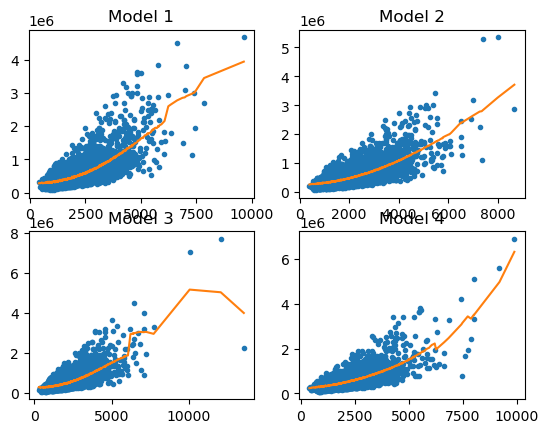

In [21]:
fig,axs = plt.subplots(2,2)
axs[0,0].plot(poly15_set_1['power_1'],poly15_set_1['price'],'.',
             poly15_set_1['power_1'],model_1.predict(features_poly1),'-')
axs[0,0].set_title('Model 1')

axs[0,1].plot(poly15_set_2['power_1'],poly15_set_2['price'],'.',
             poly15_set_2['power_1'],model_2.predict(features_poly2),'-')
axs[0,1].set_title('Model 2')

axs[1,0].plot(poly15_set_3['power_1'],poly15_set_3['price'],'.',
             poly15_set_3['power_1'],model_3.predict(features_poly3),'-')
axs[1,0].set_title('Model 3')

axs[1,1].plot(poly15_set_4['power_1'],poly15_set_4['price'],'.',
             poly15_set_4['power_1'],model_4.predict(features_poly4),'-')
axs[1,1].set_title('Model 4')


In [22]:
print(min(abs(model_1.coef_[0]),
          abs(model_2.coef_[0]),
          abs(model_3.coef_[0]),
          abs(model_4.coef_[0])),
      max(abs(model_1.coef_[0]),
          abs(model_2.coef_[0]),
          abs(model_3.coef_[0]),
          abs(model_4.coef_[0])))

1.552781267705459e-05 3.4317334067051986e-05


4 đồ thị cần khác nhau theo các hệ số đã thấy.

***QUIZ:  Với các mô hình đã thấy trong mỗi tập huấn luyện, gía trị tuyệt đối nhỏ nhất và lớn nhất cho hệ số của đặc trưng `power_1` là?***

# Hồi quy Ridge

Nhìn chung, bất cứ khi nào thấy trọng số thay đổi quá nhiều đế đáp ứng thay đổi trong dữ liệu thì phương sai của ước tính cũng lớn. Hồi quy Ridge giúp giải quyết vấn đề này bằng cách phạt các trọng số "lớn" (Các trọng số của `model15` trông khá nhỏ nhưng chúng không hề nhỏ vì đầu vào 'sqft_living' theo đơn vị hàng nghìn).

Với đối số `l2_penalty=1e3`, hãy khớp mô hình đa thức bậc 15 trong `set_1`, `set_2`, `set_3` và `set_4`. Ngoài thay đổi trong `l2_penalty`, code <u>cũng cần tương tự</u> như phép thử trên.

In [23]:
l2_penalty=1e3

In [24]:
rigde_set_1 = Ridge(alpha=l2_penalty).fit(features_poly1,labels_set_1)
rigde_set_2 = Ridge(alpha=l2_penalty).fit(features_poly2,labels_set_2)
rigde_set_3 = Ridge(alpha=l2_penalty).fit(features_poly3,labels_set_3)
rigde_set_4 = Ridge(alpha=l2_penalty).fit(features_poly4,labels_set_4)

C:\Users\NCPC\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.85805e-35): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\NCPC\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.41545e-35): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\NCPC\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.14304e-34): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\NCPC\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.48989e-35): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


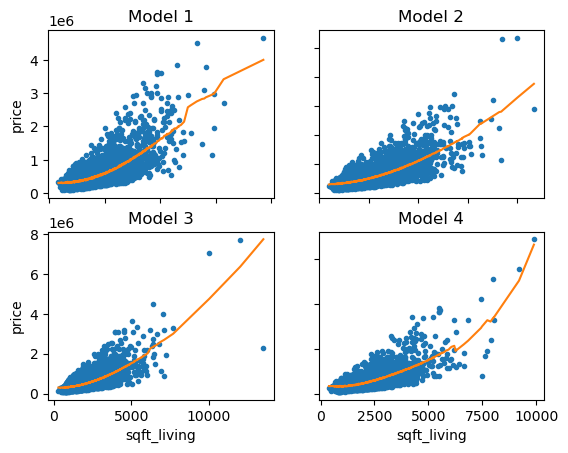

In [25]:

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(poly15_set_1['power_1'],poly15_set_1['price'],'.',
        poly15_set_1['power_1'], rigde_set_1.predict(features_poly1),'-')
axs[0, 0].set_title('Model 1')

axs[0, 1].plot(poly15_set_2['power_1'],poly15_set_2['price'],'.',
        poly15_set_2['power_1'], rigde_set_2.predict(features_poly2),'-')
axs[0, 1].set_title('Model 2')

axs[1, 0].plot(poly15_set_3['power_1'],poly15_set_3['price'],'.',
        poly15_set_3['power_1'], rigde_set_2.predict(features_poly3),'-')
axs[1, 0].set_title('Model 3')

axs[1, 1].plot(poly15_set_4['power_1'],poly15_set_4['price'],'.',
        poly15_set_4['power_1'], rigde_set_4.predict(features_poly4),'-')
axs[1, 1].set_title('Model 4')

for ax in axs.flat:
    ax.set(xlabel='sqft_living', ylabel='price')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [29]:
print(min(model_1.coef_[0],
      model_2.coef_[0],
      model_3.coef_[0],
      model_4.coef_[0]),
      max(model_1.coef_[0],
      model_2.coef_[0],
      model_3.coef_[0],
      model_4.coef_[0],))

1.552781267705459e-05 3.4317334067051986e-05


Các đồ thị thay đổi khá ít, giờ hãy áp dụng điều chuẩn bậc cao hơn.

***QUIZ:  Với các mô hình đã thấy có điều chuẩn mức độ cao hơn trong từng tập huấn luyện, giá trị nhỏ nhất và lớn nhất cho hệ số của đặc trưng `power_1` là bao nhiêu?*** (Với câu này, các số âm nhỏ hơn số dương, chẳng hạn: -5 < -3 < 5,..)

## Chọn L2 penalty qua kiểm định chéo 

Cũng giống như bậc đa thức, L2 penalty là tham số mà chúng ta cần lựa chọn. Chúng ta có thể sử dụng tập kiểm định như đã làm trước đó, nhưng cách tiếp cận này có một nhược điểm lớn: nó để lại ít quan sát hơn cho việc huấn luyện. **Kiểm định chéo** khắc phục vấn đề này bằng cách sử dụng tất cả các tập huấn luyện một cách thông minh.

Chúng ta sẽ triển khai một loại kiểm định chéo là **kiểm định chéo k-fold**. Phương thức này có tên như vậy vì nó liên quan đến việc chia tập huấn luyện thành k segment (phân đoạn) có kích thước như nhau. Tương tự như phương pháp tập kiểm định, chúng ta đo lỗi kiểm định với một trong các phân đoạn được chỉ định làm tập kiểm định. Khác biệt chính là chúng ta lặp lại quy trình k lần như sau:

Đặt segment 0 là tập kiểm định, khớp mô hình với các dữ liệu còn lại và đánh giá nó trên tập kiểm định này.<br>
Đặt segment 1 là tập kiểm định, khớp mô hình với các dữ liệu còn lại và đánh giá nó trên tập kiểm định này.<br>
...<br>
Đặt segment k-1 là tập kiểm định, khớp mô hình với các dữ liệu còn lại và đánh giá nó trên tập kiểm định này.

Sau quá trình này, chúng ta tính giá trị trung bình của k lỗi kiểm định và sử dụng nó để ước tính sai số tổng quát hóa. Lưu ý rằng tất cả các quan sát được sử dụng cho cả huấn luyện và kiểm định khi lặp lại các phân đoạn dữ liệu.

Để ước tính tốt sai số tổng quát hóa, cần xáo trộn dữ liệu huấn luyện trước khi chia chúng thành các segment. Sklearn có hàm shuffle nên chúng ta sẽ sử dụng hàm này. 

In [30]:
train_and_validation, test_data = train_test_split(full_data, train_size=0.9, test_size=0.1, random_state=1)
train_and_validation = sklearn.utils.shuffle(train_and_validation, random_state=1)

Khi dữ liệu đã được xáo trộn, chúng ta sẽ chia nó thành các segment bằng nhau, mỗi segment sẽ nhận `n/k` phần tử, trong đó `n` là số lượng quan sát trong tập huấn luyện còn `k` là số lượng segment. Do segment 0 bắt đầu tại chỉ mục 0 và chứa `n/k` phần tử nên nó sẽ chấm dứt ở chỉ mục `(n/k)-1`. Segment 1 bắt đầu tại vị trí của segment 0 ở chỉ mục `(n/k)`.Với `n/k` phần tử, segment 1 ngừng ở chỉ mục `(n*2/k)-1`. Tiếp tục cho tới chỉ mục `i` bắt đầu tại chỉ mục `(n*i/k)` và ngừng ở `(n*(i+1)/k)-1`.

Với mô hình này, chúng ta viết một vòng lặp ngắn in các chỉ số bắt đầu và kết thúc của mỗi segment để đảm bảo chúng ta đang thực hiện đúng các phân tách.

In [31]:
n = len(train_and_validation)
k = 10 # kiểm định chéo 10-fold 

for i in range(k):
    start = (n*i)//k
    end = (n*(i+1))//k-1
    print(i, (start, end))

0 (0, 1944)
1 (1945, 3889)
2 (3890, 5834)
3 (5835, 7779)
4 (7780, 9724)
5 (9725, 11669)
6 (11670, 13614)
7 (13615, 15559)
8 (15560, 17504)
9 (17505, 19450)


Một trong những ưu điểm của thư viện dữ liệu nói chung là khả năng chấp nhận các slice. Để trích xuất một slice liên tục từ DataFrame, hãy sử dụng dấu hai chấm ":" trong dấu ngoặc vuông "[]". Ví dụ: cell sau đây trích xuất các hàng từ 0 đến 9 của `train_and_validation`. Lưu ý rằng chỉ mục đầu tiên (0) được chứa trong slice nhưng chỉ mục cuối cùng (10) bị bỏ qua.

In [32]:
train_and_validation[0:10] # rows 0 to 9

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
6123600285,20141107T000000,185000.0,3,1.50,1010,7755,1.0,0,0,3,6,1010,0,1953,0,98148,47.4238,-122.332,1270,8350
3323059027,20140528T000000,326000.0,3,2.75,1720,28000,1.0,0,0,4,7,1720,0,1958,0,98058,47.4375,-122.176,2000,41817
5316100920,20140725T000000,2250000.0,3,4.25,5150,7800,2.5,0,2,3,11,4170,980,1954,0,98112,47.6288,-122.282,4270,7800
4315700175,20140612T000000,440000.0,3,1.00,1210,5750,1.5,0,0,4,7,1210,0,1910,0,98136,47.5403,-122.391,1160,5000
303000445,20140523T000000,175000.0,2,1.00,1300,44431,1.0,0,0,5,6,1300,0,1958,0,98001,47.3270,-122.267,1470,14850
2130410050,20140513T000000,287000.0,3,2.25,1490,9600,1.0,0,0,4,7,1170,320,1987,0,98019,47.7378,-121.977,1590,10104
7972601885,20150430T000000,350000.0,5,1.75,1380,7620,1.0,0,0,3,7,1180,200,1955,0,98106,47.5279,-122.345,1990,7620
3362400511,20150304T000000,570000.0,3,1.75,1260,3328,1.0,0,0,5,6,700,560,1905,0,98103,47.6823,-122.349,1380,3536
7889600190,20150113T000000,229000.0,3,1.00,1590,6240,1.0,0,0,3,7,1060,530,1956,0,98146,47.4936,-122.337,1410,6240


Giờ hãy trích xuất segment riêng với cắt mảng. Chúng ta nhóm các ngôi nhà trong dataframe `train_and_validation` thành k=10 segment có kích thước như nhau với chỉ mục đầu và kết thúc được tính như trên. Trích xuất segment thứ 4 (segment 3) và gán nó cho biến `validation4`. 

In [35]:
start = (n * 3)//k
end = (n *(3+1))//k-1
validation4 = train_and_validation[start:end]


Để xác minh rằng chúng ta đã trích xuất đúng các phần tử, hãy chạy cell sau, cell này sẽ tính giá trung bình của segment thứ tư. Khi làm tròn đến số nguyên gần nhất, giá trị trung bình sẽ là 544,330 USD.

In [36]:
print( round(validation4['price'].mean(), 0) )

545311.0


Sau khi chỉ định một trong k segment làm tập kiểm định, chúng ta huấn luyện một mô hình với dữ liệu còn lại. Để chọn phần còn lại, chúng ta cắt (0:start) và (end+1:n) của dữ liệu và paste chúng lại với nhau. DataFrame có phương thức `append()` paste hai tập hợp hàng rời rạc từ một tập dữ liệu chung. Ví dụ: cell sau sẽ paste hàng đầu tiên và cuối cùng của dataframe `train_and_validation`.

In [37]:
n = len(train_and_validation)
first_two = train_and_validation[0:2]
last_two = train_and_validation[n-2:n]
print(first_two.append(last_two))

                       date      price  bedrooms  bathrooms  sqft_living  \
id                                                                         
6123600285  20141107T000000   185000.0         3       1.50         1010   
3323059027  20140528T000000   326000.0         3       2.75         1720   
6151800612  20150107T000000   162000.0         4       1.00         1460   
1088100450  20140725T000000  1720000.0         5       4.00         4590   

            sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
id                                                                             
6123600285      7755     1.0           0     0          3      6        1010   
3323059027     28000     1.0           0     0          4      7        1720   
6151800612     16638     1.0           0     0          4      6        1460   
1088100450     35046     2.0           0     0          3     10        4590   

            sqft_basement  yr_built  yr_renovated  zipcode    

C:\Users\NCPC\AppData\Local\Temp\ipykernel_944\2964745986.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  print(first_two.append(last_two))


Trích xuất phần dữ liệu còn lại sau khi đã *loại trừ* segment thứ 4 (segment 3) và gán tập con cho `train4`.

In [38]:
# segment thứ 4 bắt đầu và kết thúc ở đâu? .append có tác dụng gì?
train4 = train_and_validation[0:start].append(train_and_validation[end+1:n])

C:\Users\NCPC\AppData\Local\Temp\ipykernel_944\3428616077.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train4 = train_and_validation[0:start].append(train_and_validation[end+1:n])


Để xác minh rằng chúng ta đã trích xuất đúng các phần tử, hãy chạy cell sau, cell này sẽ tính giá trung bình của segment thứ tư. Khi làm tròn đến số nguyên gần nhất, giá trị trung bình sẽ là 540,120 USD.

In [39]:
print( round(train4['price'].mean(), 0) )

540120.0


Chúng ta đã sẵn sàng để triển khai kiểm định chéo k-fold. Viết một hàm tính k lỗi kiểm định bằng cách chỉ định từng segment trong số k segment làm tập kiểm định. Nó chấp nhận dưới dạng các tham số (i) `k`, (ii) `l2_penalty`, (iii) dataframe, (iv) tên của cột đầu ra (ví dụ: `price`) và (v) danh sách tên các đặc trưng. Hàm trả về lỗi kiểm định trung bình bằng cách sử dụng k segment làm tập kiểm định.

* Với từng i trong [0, 1, ..., k-1]:
  * Tính chỉ mục bắt đầu và kết thúc của segment i và gọi 'start' và 'end'
  * Tạo tập kiểm định bằng cách lấy slice (start:end+1) từ dữ liệu.  
  * Tạo tập kiểm định bằng cách nối slice (end+1:n) với cuối của slice (0:start). 
  * Huấn luyện mô hình tuyến tính dùng tập huấn luyện vừa tạo với l2_penalty đã cho. 
  * Tính lỗi kiểm định sử dụng tập kiểm định vừa tạo. 

Sklearn cũng có hàm `mean_squared_error` tích hợp sẵn.

In [47]:
from sklearn.metrics import mean_squared_error

def k_fold_cross_validation(k, l2_penalty, data, output_name, features_list):
    n = len(data)
    mean_error = 0
    for i in range(k):
      start = (n * i) // k
      end = (n*(i+1)) // k-1

      validation = data[start:end+1]
      training = data[0:start].append(data[end+1:n])

      model = Ridge(alpha = l2_penalty).fit(training[features_list].values, training[output_name].values)

      mean_error += mean_squared_error(validation[output_name].values, model.predict(validation[features_list].values))
    return (mean_error / k)

Chúng ta đã có một hàm tính toán lỗi kiểm định trung bình cho mô hình, hãy viết một vòng lặp để tìm mô hình tối thiểu hóa lỗi kiểm định trung bình, thực hiện như sau:
* Chúng ta sẽ khớp mô hình đa thức bậc 15 sử dụng đầu vào `sqft_living`.
* Với `l2_penalty` trong [10^0, 10^0.5, 10^1, 10^1.5, ..., 10^2] (trong Python, chúng ta sẽ dùng hàm Numpy sau: `np.logspace(0, 10, num=21)`.)
    * Chạy kiểm định chéo 10-fold với `l2_penalty`
* Báo lại L2 penalty nào cho lỗi kiểm định trung bình thấp nhất.

Lưu ý: vì bậc của đa thức hiện được cố định là 15, để mọi thứ nhanh hơn, chúng ta hãy tạo các đặc trưng của đa thức trước và sử dụng lại chúng trong suốt vòng lặp. Hãy dùng `train_and_validation` khi tạo các đối tượng đa thức!

Nếu thấy nhiều màu đỏ từ `scipy.linalg.solve`, hãy import `warnings` và sử dụng `warnings.filterwarnings('ignore')`. Đây không phải là phương pháp tốt nhất nhưng lại hữu ích. Sau khi đã hoàn tất, hãy đặt `warnings.resetwarnings()` để chuyển nó trở lại bình thường.

In [48]:
import warnings
warnings.filterwarnings('ignore')
data = polynomial_dataframe(train_and_validation['sqft_living'], 15)

features = data.columns

data['price'] = train_and_validation['price']

k = 10

arr_errors = []
for l2_penalty in np.logspace(0, 10, num=21):
  arr_errors.append(k_fold_cross_validation(k, l2_penalty, data, 'price', features))

arr_errors


[65982812110.799255,
 65982812096.45408,
 65982812051.0906,
 65982811907.6393,
 65982811454.00603,
 65982810019.498856,
 65982805483.2478,
 65982791138.95668,
 65982745784.25974,
 65982602419.45648,
 65982149652.72839,
 65980723779.13521,
 65976272984.47843,
 65962756471.07561,
 65924926809.387535,
 65839673606.52464,
 65716806811.286255,
 65621019138.10636,
 65576295887.10531,
 65560158471.7108,
 65554837975.93205]

***QUIZ:  Giá trị tốt nhất cho L2 penalty theo kiểm định 10-fold là bao nhiêu?***

In [50]:
best_l2_penalty = np.logspace(0, 10, num = 21)[arr_errors.index(min(arr_errors))]
best_l2_penalty

10000000000.0

Sẽ rất hữu ích khi vẽ các lỗi kiểm định chéo k-fold mà chúng ta có được để hiểu rõ hơn cách xử lý của phương thức. Chúng ta cũng có thể dùng `plt.xscale('log')` cho biểu đồ trực quan. [Quitter.](https://xkcd.com/1162/)

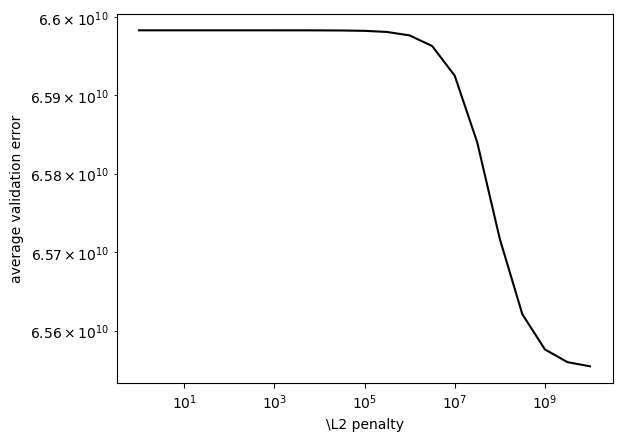

In [52]:
# Vẽ các giá trị l2-penalty (có thể trong log) trên trục x và lỗi kiểm định chéo trên trục y
plt.plot(np.logspace(0,10, num = 21), arr_errors, 'k-')
plt.xlabel('\L2 penalty')
plt.ylabel('average validation error')
plt.xscale('log')
plt.yscale('log')



Khi đã tìm thấy giá trị tốt nhất cho L2 penalty bằng kiểm định chéo, cần huấn luyện lại mô hình cuối cùng trong tất cả dữ liệu huấn luyện sử dụng `l2_penalty`. Theo cách này, mô hình cuối sẽ được huấn luyện trong toàn bộ tập dữ liệu.

***QUIZ: Với L2 penalty tốt nhất tìm thấy ở trên, hãy huấn luyện một mô hình sử dụng tất cả dữ liệu huấn luyện. RSS trong dữ liệu KIỂM TRA của mô hình với L2 penalty đó là bao nhiêu? ***

In [55]:
poly_data = polynomial_dataframe(train_and_validation['sqft_living'],15)
features = data.columns

data['price'] = train_and_validation['price']
model_l2 = Ridge(alpha=best_l2_penalty).fit(poly_data,data['price'].values)

In [57]:
predictions = model_l2.predict(polynomial_dataframe(test_data['sqft_living'],15))
residuals = predictions - test_data['price'].values
residuals.dot(residuals)

139812500297123.16